# A Deep Learning Approach to Quantifying COVID 19 Reporting Inaccuracies in the US
## CS230 Final Project 2021
### Sameer Sundrani and Amy Zhang
### TA Mentor: Ruta & Ayush

# Imported Libraries & gDrive Mounting

In [1]:
import numpy as np
import pandas as pd
import time
#TO DO: IMPORT ALL FILES HERE
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import explained_variance_score #for linear regression evaluation
from sklearn import linear_model
from sklearn import preprocessing
#END TO DO
from google.colab import drive

In [2]:
drive.mount('/content/drive', force_remount=True)
FOLDERNAME = '/content/drive/MyDrive/Colab Notebooks/CS230_FINAL_PROJECT'


Mounted at /content/drive


# Data Processing & Dataset Preparation

In [3]:
travel_data_raw = pd.read_csv(FOLDERNAME + "/Trips_by_Distance.csv")
covid_counts_raw = pd.read_csv(FOLDERNAME + "/us-counties.csv")

In [4]:
#travel_data_raw.head()
travel_counties = travel_data_raw.loc[travel_data_raw['Level'] == "County"]
travel_counties_final = travel_counties[['Date', 'State Postal Code', 'County Name', 'Number of Trips', 'Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5', 'Number of Trips 5-10', 'Number of Trips 10-25', 'Number of Trips 25-50', 'Number of Trips 50-100', 'Number of Trips 100-250', 'Number of Trips 250-500', 'Number of Trips >=500']]
travel_counties_final['County Name'] = travel_counties_final['County Name'].apply(lambda x: x.split(" ")[0])
travel_counties_final = travel_counties_final.rename(columns={"Date": "date", "State Postal Code": "state", "County Name": "county"})
travel_counties_final.head()

<ipython-input-4-d2c24e945073>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  travel_counties_final['County Name'] = travel_counties_final['County Name'].apply(lambda x: x.split(" ")[0])


,date,state,county,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
52,2020/01/21,NY,Hamilton,18285.0,3025.0,2790.0,1196.0,4534.0,4854.0,1467.0,283.0,38.0,98.0,0.0
53,2020/01/21,NM,Doña,913920.0,218380.0,265268.0,141106.0,132456.0,91822.0,36900.0,20212.0,5245.0,1837.0,694.0
54,2020/01/21,AK,Bristol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,2020/01/21,VA,Louisa,147505.0,24957.0,29645.0,19679.0,18592.0,28460.0,19974.0,5247.0,785.0,117.0,49.0
56,2020/01/21,VA,Loudoun,1445859.0,351327.0,332129.0,160314.0,198232.0,268757.0,113140.0,13122.0,5814.0,1395.0,1629.0


In [5]:
print("Number of Total Inputs: ", len(travel_counties_final))

Number of Total Inputs:  1973176


In [6]:
covid_counts_final = covid_counts_raw[['date', 'county', 'state', 'cases']]
covid_counts_final['date'] = covid_counts_final['date'].apply(lambda x: x.replace('-', '/'))
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "Virgin Islands": "VI",
}
covid_counts_final['state'] = covid_counts_final['state'].apply(lambda x: us_state_to_abbrev[x])
covid_counts_final.head()

<ipython-input-6-9e1ffaf335ab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_counts_final['date'] = covid_counts_final['date'].apply(lambda x: x.replace('-', '/'))
<ipython-input-6-9e1ffaf335ab>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_counts_final['state'] = covid_counts_final['state'].apply(lambda x: us_state_to_abbrev[x])


,date,county,state,cases
0,2020/01/21,Snohomish,WA,1
1,2020/01/22,Snohomish,WA,1
2,2020/01/23,Snohomish,WA,1
3,2020/01/24,Cook,IL,1
4,2020/01/24,Snohomish,WA,1


In [7]:
final_data = pd.merge(covid_counts_final, travel_counties_final)
final_data.head()

,date,county,state,cases,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
0,2020/01/21,Snohomish,WA,1,2944078.0,762651.0,726576.0,308236.0,417195.0,540130.0,159563.0,20442.0,4391.0,1152.0,3742.0
1,2020/01/22,Snohomish,WA,1,3006800.0,784271.0,732019.0,311760.0,432308.0,551873.0,165546.0,21241.0,3654.0,1031.0,3097.0
2,2020/01/23,Snohomish,WA,1,2952207.0,782244.0,724152.0,305706.0,405046.0,535931.0,167202.0,22195.0,5095.0,1135.0,3501.0
3,2020/01/24,Cook,IL,1,21307310.0,6266951.0,5185299.0,2574174.0,3260629.0,2988478.0,774147.0,130659.0,86057.0,24356.0,16560.0
4,2020/01/24,Snohomish,WA,1,3167046.0,857787.0,779656.0,334594.0,448890.0,550137.0,160682.0,23484.0,6369.0,1343.0,4104.0


In [8]:
final_data.to_csv(FOLDERNAME+'/final_data.csv')

In [9]:
print("Number of Total Inputs: ", len(final_data))
# print("Confirmed (number should be the same): ",np.sum(final_data.groupby('county').size().to_list()))
print("Number of Total Counties: " ,len(final_data.groupby('county').size().to_list()))

Number of Total Inputs:  791981
Number of Total Counties:  1620


# Initial Data Visualization - Number Recorded Days per County (Initial Distribution)

Text(0, 0.5, 'Number of Recorded Days')

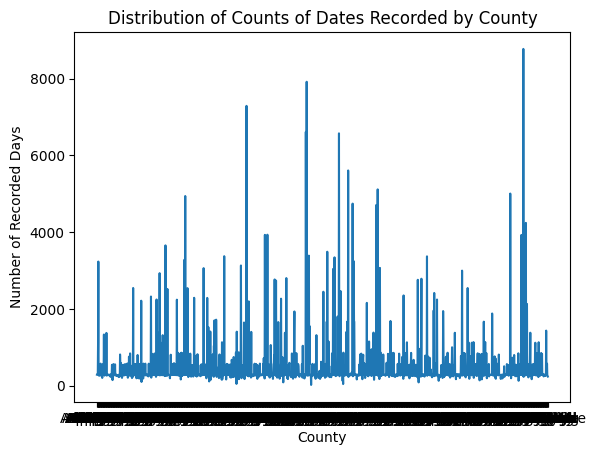

In [10]:
cases_by_county_df = final_data.groupby('county').size()
plt.plot(cases_by_county_df)
plt.title('Distribution of Counts of Dates Recorded by County')
plt.xlabel('County')
plt.ylabel('Number of Recorded Days')

# Initial Modeling (Begin **Here** if Data is Preprocessed)

In [11]:
final_data = pd.read_csv(FOLDERNAME+'/final_data.csv').iloc[0:, 1:]
final_data = final_data.dropna()
final_data.head()

,date,county,state,cases,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
0,2020/01/21,Snohomish,WA,1,2944078.0,762651.0,726576.0,308236.0,417195.0,540130.0,159563.0,20442.0,4391.0,1152.0,3742.0
1,2020/01/22,Snohomish,WA,1,3006800.0,784271.0,732019.0,311760.0,432308.0,551873.0,165546.0,21241.0,3654.0,1031.0,3097.0
2,2020/01/23,Snohomish,WA,1,2952207.0,782244.0,724152.0,305706.0,405046.0,535931.0,167202.0,22195.0,5095.0,1135.0,3501.0
3,2020/01/24,Cook,IL,1,21307310.0,6266951.0,5185299.0,2574174.0,3260629.0,2988478.0,774147.0,130659.0,86057.0,24356.0,16560.0
4,2020/01/24,Snohomish,WA,1,3167046.0,857787.0,779656.0,334594.0,448890.0,550137.0,160682.0,23484.0,6369.0,1343.0,4104.0


In [12]:
#Quick Check for NA/NaN in data
final_data.isnull().any()

date                       False
county                     False
state                      False
cases                      False
Number of Trips            False
Number of Trips <1         False
Number of Trips 1-3        False
Number of Trips 3-5        False
Number of Trips 5-10       False
Number of Trips 10-25      False
Number of Trips 25-50      False
Number of Trips 50-100     False
Number of Trips 100-250    False
Number of Trips 250-500    False
Number of Trips >=500      False
dtype: bool

In [13]:
#Check Dates: 
dates_ordered = final_data.groupby('date')
dates_ordered.head()

,date,county,state,cases,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
0,2020/01/21,Snohomish,WA,1,2944078.0,762651.0,726576.0,308236.0,417195.0,540130.0,159563.0,20442.0,4391.0,1152.0,3742.0
1,2020/01/22,Snohomish,WA,1,3006800.0,784271.0,732019.0,311760.0,432308.0,551873.0,165546.0,21241.0,3654.0,1031.0,3097.0
2,2020/01/23,Snohomish,WA,1,2952207.0,782244.0,724152.0,305706.0,405046.0,535931.0,167202.0,22195.0,5095.0,1135.0,3501.0
3,2020/01/24,Cook,IL,1,21307310.0,6266951.0,5185299.0,2574174.0,3260629.0,2988478.0,774147.0,130659.0,86057.0,24356.0,16560.0
4,2020/01/24,Snohomish,WA,1,3167046.0,857787.0,779656.0,334594.0,448890.0,550137.0,160682.0,23484.0,6369.0,1343.0,4104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789083,2020/12/31,Autauga,AL,4190,197303.0,43649.0,50455.0,24460.0,28822.0,35085.0,8685.0,3637.0,2060.0,410.0,40.0
789084,2020/12/31,Baldwin,AL,13601,696981.0,127067.0,174473.0,96370.0,128608.0,119501.0,33645.0,9740.0,5520.0,1822.0,235.0
789085,2020/12/31,Barbour,AL,1514,96265.0,20820.0,21854.0,11714.0,16862.0,14545.0,6783.0,2912.0,613.0,149.0,13.0
789086,2020/12/31,Bibb,AL,1834,86984.0,14690.0,19876.0,10083.0,15306.0,14776.0,9459.0,1961.0,741.0,74.0,18.0


In [14]:
print("To Confirm: Number of Total Inputs: (should <= 1609217 (b/c of some previous null values)) ", len(final_data))

To Confirm: Number of Total Inputs: (should <= 1609217 (b/c of some previous null values))  790923


In [15]:
# normalize travel data portion of final_data to have zero mean and unit variance to optimize learning
scaler = preprocessing.StandardScaler().fit(final_data.iloc[:, 4:])
final_data.iloc[:, 4:] =  scaler.transform(final_data.iloc[:, 4:])
final_data.head()

,date,county,state,cases,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
0,2020/01/21,Snohomish,WA,1,3.214956,3.065878,3.210308,2.770819,3.008435,4.047446,3.733404,1.153280,0.268286,0.359057,2.489360
1,2020/01/22,Snohomish,WA,1,3.291343,3.162302,3.237152,2.806761,3.130827,4.143485,3.889096,1.217817,0.147987,0.282531,2.021758
2,2020/01/23,Snohomish,WA,1,3.224856,3.153262,3.198353,2.745014,2.910047,4.013105,3.932189,1.294873,0.383197,0.348305,2.314644
3,2020/01/24,Cook,IL,1,25.579129,27.614850,25.199837,25.881703,26.035848,24.071013,19.726308,10.055701,13.598374,15.034359,11.781960
4,2020/01/24,Snohomish,WA,1,3.486503,3.490181,3.472088,3.039651,3.265115,4.129287,3.762523,1.398988,0.591148,0.479854,2.751798


<Axes: title={'center': 'Cases over Time'}, xlabel='date', ylabel='Log Cases'>

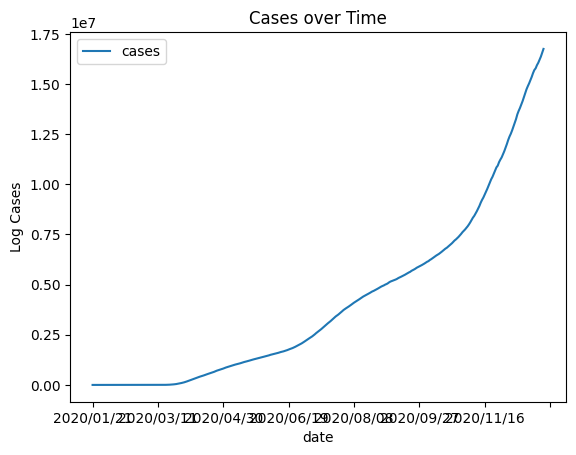

In [16]:
# See cases over the entire dataset, grouped by day
dates_ordered[['date', 'cases']].sum('cases').plot(title='Cases over Time', ylabel='Log Cases')

**Define Train, Val, Test Sets and Normalize All Feature Vectors**

In [17]:
# shuff = final_data.sample(frac=1)
# X = shuff.iloc[:,4:] #if wanted to shuffle data before splits
time_split_all_data = final_data[['cases', 'Number of Trips <1',	'Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500']].copy() #if we want to just use split by time
#min_max_scaler = preprocessing.MinMaxScaler()
#time_split_all_data[['Number of Trips <1',	'Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500']] = min_max_scaler.fit_transform(time_split_all_data[['Number of Trips <1',	'Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500']])

xy_train = time_split_all_data.iloc[160291:, :] #train on later part of data
X_train = xy_train.iloc[:, 1:]
y_train = xy_train['cases']

xy_val_test = time_split_all_data.iloc[0:160290, :] #val and test on beginning of data
X_val_test = xy_val_test.iloc[:, 1:]
y_val_test = xy_val_test['cases']

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.50)

In [18]:
print("Train Set Dimensions : ", X_train.shape)
print("Train Labels Dimensions : ", y_train.shape)
print("Val Set Dimensions : ", X_val.shape)
print("Val Labels Dimensions : ", y_val.shape)
print("Test Set Dimensions : ", X_test.shape)
print("Test Labels Dimensions : ", y_test.shape)

Train Set Dimensions :  (630632, 10)
Train Labels Dimensions :  (630632,)
Val Set Dimensions :  (80145, 10)
Val Labels Dimensions :  (80145,)
Test Set Dimensions :  (80145, 10)
Test Labels Dimensions :  (80145,)


In [19]:
X_train.head()

,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500
160299,-0.307607,-0.357208,-0.364188,-0.367688,-0.359084,-0.396391,-0.387845,-0.321943,-0.310072,-0.207509
160300,0.033291,0.007932,-0.045676,-0.161162,-0.166180,-0.121595,0.488690,0.470524,0.403961,-0.041492
160301,-0.274549,-0.299477,-0.287674,-0.307193,-0.320719,-0.321030,-0.308608,-0.015892,-0.156387,-0.177785
160302,-0.276922,-0.259643,-0.327859,-0.326986,-0.312426,-0.343461,-0.336313,-0.311660,-0.156387,-0.169811
160303,-0.002955,-0.067125,-0.126046,-0.153663,-0.142675,0.031130,0.232886,0.854433,0.042833,-0.077015


In [20]:
#Double check that we have no null/NA values
X_train.isnull().any()

Number of Trips <1         False
Number of Trips 1-3        False
Number of Trips 3-5        False
Number of Trips 5-10       False
Number of Trips 10-25      False
Number of Trips 25-50      False
Number of Trips 50-100     False
Number of Trips 100-250    False
Number of Trips 250-500    False
Number of Trips >=500      False
dtype: bool

Text(0, 0.5, 'Case Count')

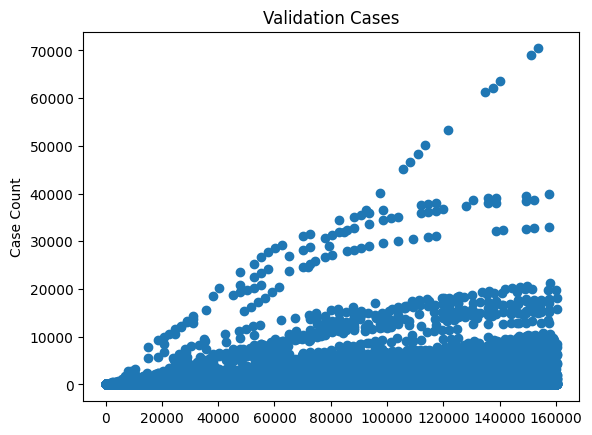

In [21]:
plt.scatter(X_val.index, y_val, marker='o')
plt.title('Validation Cases')
plt.ylabel('Case Count')

Text(0, 0.5, 'Case Count')

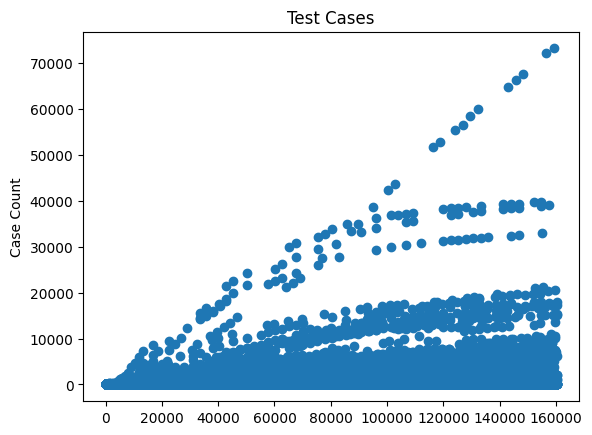

In [22]:
plt.scatter(X_test.index, y_test, marker='o')
plt.title('Test Cases')
plt.ylabel('Case Count')

Text(0, 0.5, 'Case Count')

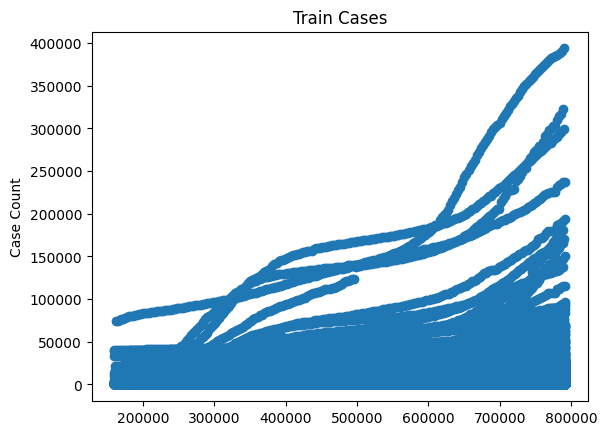

In [23]:
plt.scatter(X_train.index, y_train, marker='o')
plt.title('Train Cases')
plt.ylabel('Case Count')

## Lasso Regression (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV) (L1 Regression)

In [24]:
print("STARTING MODEL FITTING")
start=time.time()
reg_lasso = linear_model.LassoCV(random_state=1, max_iter=100000).fit(X_train, y_train)
stop=time.time()
print("MODEL FITTING FINISHED -- Total Time = ", stop-start, ' ms')

STARTING MODEL FITTING
MODEL FITTING FINISHED -- Total Time =  16.050652027130127  ms


In [25]:
reg_lasso_params = reg_lasso.get_params()
print(reg_lasso_params)

{'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'max_iter': 100000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': 1, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': False}


In [26]:
print(reg_lasso.coef_)
print(reg_lasso.intercept_)

[-11068.50951905  17477.66482254    630.6974931       0.
    947.42519759      0.          -1253.08916095   -468.53535165
   1443.96319768   -709.49647677]
2376.8918480874368


In [27]:
y_pred = reg_lasso.predict(X_val)
exp_var_score = explained_variance_score(y_val, y_pred)
print("Score = ", exp_var_score) #Note that 1.0 is the best

Score =  -23.650129225723052


Text(0, 0.5, 'Predicted')

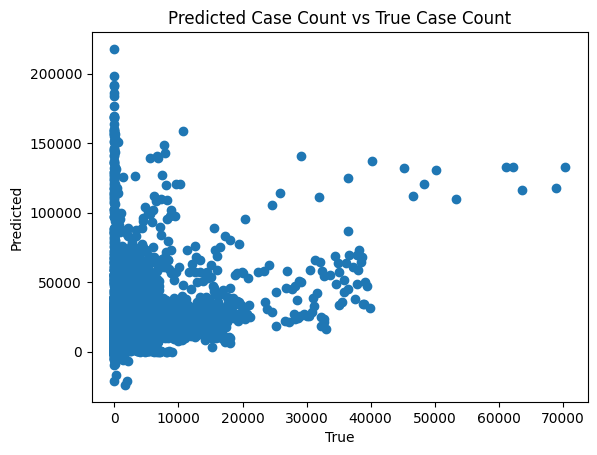

In [28]:
plt.scatter(y_val, y_pred) #Should be a straight line
plt.title('Predicted Case Count vs True Case Count')
plt.xlabel('True')
plt.ylabel('Predicted')

##Ridge Regression (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) (L2 Regression)

In [29]:
print("STARTING MODEL FITTING")
start=time.time()
reg_ridge = linear_model.RidgeCV().fit(X_train, y_train)
stop=time.time()
print("MODEL FITTING FINISHED -- Total Time = ", stop-start, ' ms')

STARTING MODEL FITTING
MODEL FITTING FINISHED -- Total Time =  0.915764331817627  ms


In [30]:
reg_ridge_params = reg_ridge.get_params()
print(reg_ridge_params)

{'alpha_per_target': False, 'alphas': (0.1, 1.0, 10.0), 'cv': None, 'fit_intercept': True, 'gcv_mode': None, 'scoring': None, 'store_cv_values': False}


In [31]:
print(reg_ridge.coef_)
print(reg_ridge.intercept_)

[-11865.9983621   18233.67327504   1618.3272502   -1367.09265399
   1565.81748309   -176.43240177  -1298.43141105   -571.46262909
   1574.49370248   -741.20804866]
2376.9290607044704


In [32]:
y_pred = reg_ridge.predict(X_val)
exp_var_score = explained_variance_score(y_val, y_pred)
print("Score = ", exp_var_score) #Note that 1.0 is the best

Score =  -23.616435222112727


Text(0, 0.5, 'Predicted')

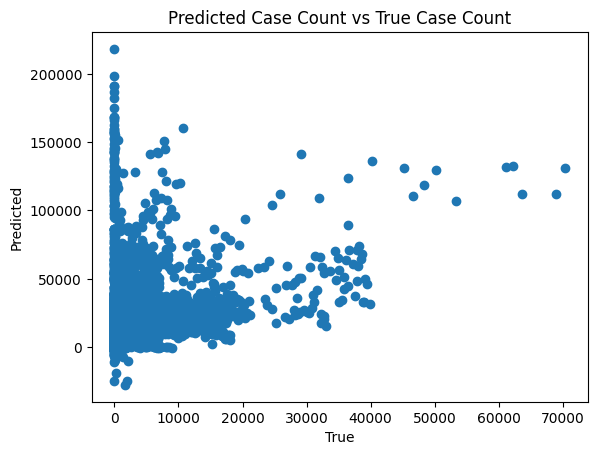

In [33]:
plt.scatter(y_val, y_pred) #Should be a straight line
plt.title('Predicted Case Count vs True Case Count')
plt.xlabel('True')
plt.ylabel('Predicted')

## Split by State (proxy for testing quality) (https://www.nytimes.com/interactive/2020/us/coronavirus-testing.html)

In [34]:
#final_data.head()
state_split_all_data = final_data[['state', 'cases', 'Number of Trips <1',	'Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500']].copy()
#First, we normalize using sklearn's MinMaxScaler()
#x2 = X2.values #returns a numpy array
#min_max_scaler = preprocessing.MinMaxScaler()
#state_split_all_data[['Number of Trips <1',	'Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500']] = min_max_scaler.fit_transform(state_split_all_data[['Number of Trips <1',	'Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500']])
state_split_all_data_normalized = state_split_all_data.sample(frac=1) #shuffle everything

X2 = state_split_all_data_normalized[['state', 'Number of Trips <1',	'Number of Trips 1-3',	'Number of Trips 3-5',	'Number of Trips 5-10',	'Number of Trips 10-25',	'Number of Trips 25-50',	'Number of Trips 50-100',	'Number of Trips 100-250', 'Number of Trips 250-500',	'Number of Trips >=500']]
y2 = state_split_all_data_normalized['cases']


In [35]:
X_train2 = X2[X2['state'].isin(['VT', 'ME', 'NY', 'RI', 'MA', 'NH', 'CT', 'HI', 'MI', 'WA', 'MD', 'NJ', 'CA'])]
X_train2 = X_train2.iloc[:, 1:]
y_train2 = y2[X2['state'].isin(['VT', 'ME', 'NY', 'RI', 'MA', 'NH', 'CT', 'HI', 'MI', 'WA', 'MD', 'NJ', 'CA'])]

X_val_test2 = X2[X2['state'].isin(['SD', 'IA', 'WY'])]
X_val_test2 = X_val_test2.iloc[:, 1:]
y_val_test2 = y2[X2['state'].isin(['SD', 'IA', 'WY'])]

X_val_states, X_test_states, y_val_states, y_test_states = train_test_split(X_val_test2, y_val_test2, test_size=0.50, random_state=1)

In [36]:
print("Train Set Dimensions : ", X_train2.shape)
print("Train Labels Dimensions : ", y_train2.shape)
print("Val Set Dimensions : ", X_val_states.shape)
print("Val Labels Dimensions : ", y_val_states.shape)
print("Test Set Dimensions : ", X_test_states.shape)
print("Test Labels Dimensions : ", y_test_states.shape)

Train Set Dimensions :  (91773, 10)
Train Labels Dimensions :  (91773,)
Val Set Dimensions :  (23306, 10)
Val Labels Dimensions :  (23306,)
Test Set Dimensions :  (23307, 10)
Test Labels Dimensions :  (23307,)


### Lasso Regression

In [37]:
print("STARTING MODEL FITTING")
start=time.time()
reg_lasso = linear_model.LassoCV(random_state=1, max_iter=100000).fit(X_train2, y_train2)
stop=time.time()
print("MODEL FITTING FINISHED -- Total Time = ", stop-start, ' ms')


STARTING MODEL FITTING
MODEL FITTING FINISHED -- Total Time =  1.5048840045928955  ms


In [38]:
y_pred_states = reg_lasso.predict(X_val_states)
exp_var_score = explained_variance_score(y_val_states, y_pred_states)
print("Score = ", exp_var_score) #Note that 1.0 is the best

print(reg_lasso.coef_)
print(reg_lasso.intercept_)


Score =  0.4184656000451302
[-4882.27964454  5942.44290756  3525.63399701    -0.
 -2068.615702    1337.19896144   298.48842448   882.9773273
  -816.27403227   -26.87641526]
1167.7462719348468


Text(0, 0.5, 'Predicted')

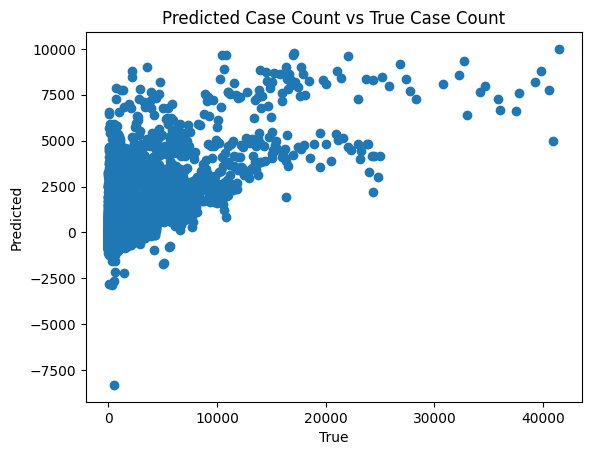

In [39]:
plt.scatter(y_val_states, y_pred_states) #Should be a straight line
plt.title('Predicted Case Count vs True Case Count')
plt.xlabel('True')
plt.ylabel('Predicted')

### Ridge Regression

In [40]:
print("STARTING MODEL FITTING")
start=time.time()
reg_ridge = linear_model.RidgeCV().fit(X_train2, y_train2)
stop=time.time()
print("MODEL FITTING FINISHED -- Total Time = ", stop-start, ' ms')

STARTING MODEL FITTING
MODEL FITTING FINISHED -- Total Time =  0.09085845947265625  ms


In [41]:
y_pred_states = reg_ridge.predict(X_val_states)
exp_var_score = explained_variance_score(y_val_states, y_pred_states)
print("Score = ", exp_var_score) #Note that 1.0 is the best

Score =  0.41718269770821614


Text(0, 0.5, 'Predicted')

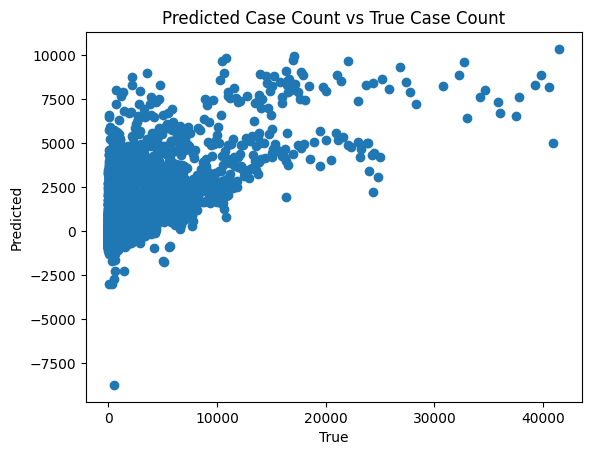

In [42]:
plt.scatter(y_val_states, y_pred_states) #Should be a straight line
plt.title('Predicted Case Count vs True Case Count')
plt.xlabel('True')
plt.ylabel('Predicted')